In [1]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import erdos_renyi_graph
import random


def generate():
    edge_index = erdos_renyi_graph(13, 0.5)
    has_lt_3_or_gt_10_neighbors = (edge_index[0].bincount() < 4) | (edge_index[0].bincount() > 9)
    return Data(x=torch.ones((13, 1)), edge_index=edge_index, y=int(has_lt_3_or_gt_10_neighbors.max()))

datalist = [
    generate() for _ in range(10000)
]
random.shuffle(datalist)
iteration = 1
train_data = datalist[:iteration * 1250] + datalist[(iteration + 1) * 1250:]
val_data = datalist[iteration * 1250 : (iteration + 1) * 1250]

train_loader = DataLoader(train_data, batch_size=8750, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1250, shuffle=False)

In [3]:
from gnnexplain.nn.gnn import GCN
from lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb

torch.set_float32_matmul_precision('medium')

model = GCN(14, 2, layers=3, dim=512, activation="ReLU", lr=1e-5, weight=weight)
logger = WandbLogger(project="gnnexplain", group=f'test')

trainer = Trainer(
    max_steps=500,
    logger=logger,
    devices=1,
    enable_checkpointing=False,
    enable_progress_bar=True,
    log_every_n_steps=1
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()	

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
/home/apluska/miniconda3/envs/gnnexplain/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name        | Type       | Params
-------------------------------------------
0 | embedding   | Linear     | 7.7 K 
1 | act         | ReLU       | 0     
2 | dropout     | Dropout    | 0     
3 | norms       | ModuleList | 4.6 K 
4 | conv_layers | ModuleList | 787 K 
5 | out         | Sequential | 263 K 
6 | loss        | NLLLoss    | 0     
-------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.256     Total estimated model params size (MB)


/home/apluska/miniconda3/envs/gnnexplain/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s, v_num=yt7n]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s, v_num=yt7n]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_f1_macro,▁▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_f1_micro,▁▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇███████████████
val_f1_macro,▁▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
val_f1_micro,▁▄▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇███████████████
val_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,499


In [1]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
import torch

dataset = TUDataset(root='data', name='Mutagenicity')
n_val = len(dataset) // 8; iteration = 1

val_data = dataset[iteration * n_val : (iteration + 1) * n_val]
train_data = dataset[:iteration * n_val] + dataset[(iteration + 1) * n_val:]

val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)

if iteration == 0:
    num_classes = train_data.datasets[1].y.max() + 1
    weight = len(train_data.datasets[1]) / (num_classes * torch.bincount(train_data.datasets[1].y, minlength=num_classes).float())
elif iteration == 7:
    num_classes = train_data.datasets[0].y.max() + 1
    weight = len(train_data.datasets[0]) / (num_classes * torch.bincount(train_data.datasets[0].y, minlength=num_classes).float())
else:
    num_classes = max(train_data.datasets[0].y.max(), train_data.datasets[1].y.max()) + 1
    bincount = torch.bincount(train_data.datasets[0].y, minlength=num_classes) + torch.bincount(train_data.datasets[1].y, minlength=num_classes)
    weight = (len(train_data.datasets[0])  + len(train_data.datasets[1])) / (num_classes * bincount.float())

train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

sample_weight = weight[train_batch.y]

In [3]:
""" from gnnexplain.nn.gnn import GNN

model = GNN.load_from_checkpoint('./checkpoints/Mutagenicity_ReLU_0b9z4g7v.ckpt') """

In [22]:
import numpy as np

labels = []
for graph, y in zip(train_batch.to_data_list(), train_batch.y):
    labels.append(y * np.ones(graph.num_nodes))
labels = np.concatenate(labels, axis=0)
labels.shape

(113750,)

In [4]:
from gnnexplain.model.gtree import _get_values

values = _get_values(train_batch, model)[:-1]
values[0].shape

/home/apluska/miniconda3/envs/gnnexplain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(115007, 512)

In [37]:
from gnnexplain.model.gtree import Explainer

explainer = Explainer(width=50, sample_size=100, layer_depth=2, max_depth=10, ccp_alpha=1e-3)

In [38]:
from cProfile import Profile
from pstats import Stats

profiler = Profile()
profiler.runcall(explainer.fit, train_batch, values, train_batch.y, sample_weight)  #model(train_batch).argmax(-1).detach().numpy()
stats = Stats(profiler)
stats.strip_dirs().sort_stats('cumulative').print_stats(30)

         1364761 function calls (1351573 primitive calls) in 37.122 seconds

   Ordered by: cumulative time
   List reduced from 582 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.195    0.016   66.261    5.522 base_events.py:1908(_run_once)
       12    0.585    0.049   42.936    3.578 selectors.py:451(select)
      121    0.002    0.000   21.957    0.181 base.py:1134(wrapper)
       60    0.159    0.003   21.265    0.354 gtree.py:182(fit)
       61    0.007    0.000   20.012    0.328 _classes.py:221(_fit)
       61   19.785    0.324   19.785    0.324 {method 'build' of 'sklearn.tree._tree.DepthFirstTreeBuilder' objects}
       60    0.002    0.000   19.107    0.318 _classes.py:1290(fit)
       60    9.073    0.151   11.920    0.199 gtree.py:213(predict)
        5    0.001    0.000    6.270    1.254 threading.py:637(wait)
        1    0.130    0.130    3.293    3.293 gtree.py:90(fit)
        4    0.281    0.070    

In [39]:
explainer.accuracy(train_batch)

0.8126482213438735

In [40]:
explainer.accuracy(val_batch)

0.7195571955719557

In [41]:
explainer.f1_score(val_batch)

0.7129877369007804

In [36]:
explainer.fidelity(val_batch, model)

0.7749077490774908

In [42]:
explainer.prune()

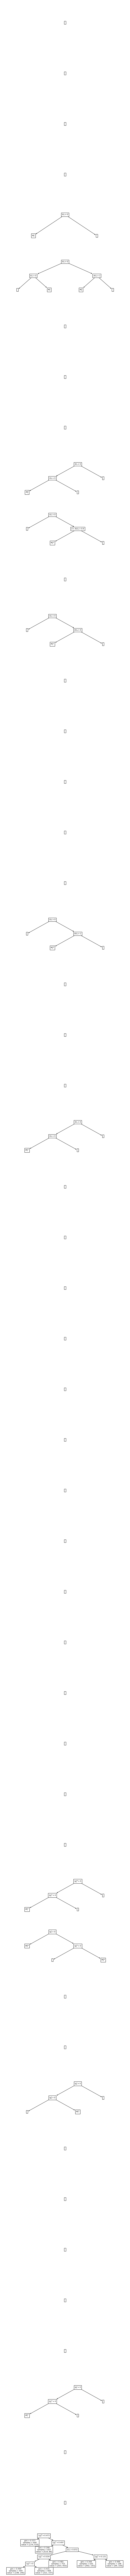

In [23]:
explainer.plot()

In [30]:
explainer.save_image('./test.png')